In [5]:
DATASET_PATH = 'SKU_Recognition_Dataset/confectionery'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain
from scipy.signal import fftconvolve
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from skimage.measure import block_reduce
import pprint
import pickle
import time

In [2]:
def create_RFS_filters(radius=24, sigmas=[1, 2, 4], n_orientations=6):
    """ Generates filters for RFS filterbank.
    Adapted from 
    Parameters
    ----------
    radius : int, default 24
        radius of all filters. Size will be 2 * radius + 1 (Default 49)

    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed

    n_orientations : int
        number of fractions the half-angle will be divided in

    Returns
    -------
    filters : ndarray (2 * len(sigmas) * n_orientations + 2, 2*radius+1, 2*radius+1)
        Contains edge filters, bar filters and rotation invariant filters 
        (Gaussian and Laplacian of Gaussion) on different scales and orientations
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = np.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= np.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        f = (gx * gy).reshape(sup, sup)
        # normalize
        f /= np.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = np.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = np.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in range(n_orientations):
            # Not 2pi as filters have symmetry
            angle = np.pi * orient / n_orientations
            c, s = np.cos(angle), np.sin(angle)
            rotpts = np.dot(np.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))
    length = np.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    edge = np.asarray(edge)
    bar = np.asarray(bar)
    rot = np.asarray(rot)
    filters = np.concatenate((edge, bar,rot), axis=0)
    return filters

### Funtion to apply filters on an image

In [3]:
def apply_filters(image, filterbank):
    """
    Parameters
    ----------
    image : ndarray containing image with 3 channels
    filterbank: ndarray containing filters
    
    Returns
    -------
    feature_vector : ndarray containing feature vectors
    """
    feature_vectors = []
    for filter_ in filterbank:
        for channel in range(3):
            # Apply filter
#             t1 = time.time()
            filtered_image = fftconvolve(image[:,:,channel], filter_, 'same')
#             t2 = time.time()
#             print("1 ", t2-t1)
            # Apply (8,8) maxpooling
            filtered_image = block_reduce(filtered_image, (8,8), np.max)
#             t3=time.time()
#             print('2 ', t3-t2)
            # Apply ReLU
            filtered_image = np.maximum(filtered_image, 0)
#             t4 = time.time()
#             print('3 ', t4-t3)
            

            feature_vectors.append(filtered_image)
            
    # return flattened feature vector
    
    flattened = np.reshape(feature_vectors, (-1))
#     t5 = time.time()
#     print('4 ', t4-t5)
    return flattened



### Create filters

In [4]:
sigmas = [1, 2, 4]
n_orientations = 6

filters = create_RFS_filters(sigmas=sigmas,
                             n_orientations=n_orientations)
len(filters)

38

### Load Dataset 

In [6]:
def get_features():
    features = []
    labels = []

    for label_ in os.listdir(DATASET_PATH):
        current_label_dir = os.path.join(DATASET_PATH, label_)
        print(label_)
        if os.path.isdir(current_label_dir) and not label_.startswith('.'):
            for image_name in os.listdir(current_label_dir):
    #             print(image_name)
                current_image_path = os.path.join(current_label_dir, image_name)
                if not os.path.isdir(current_image_path) and not image_name.startswith('.'):
                    t1 = time.time()
                    image = cv2.imread(current_image_path)
                    image = cv2.resize(image, (128,128))
                    feature = apply_filters(image, filters)
                    features.append(feature)
                    labels.append(label_)
    #                 print("Image feature calculation time: ", time.time() - t1)
    
    with open('features.pickle', 'wb') as f:
        pickle.dump(features, f)

    with open('labels.pickle', 'wb') as f:
        pickle.dump(labels, f)
    return features, labels 


In [7]:
# features, labels = get_features()

with open('features.pickle', 'rb') as f:
    features = pickle.load(f)

with open('labels.pickle', 'rb') as f:
    labels = pickle.load(f)

### Split dataset into training and test sets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=53)

### Decision Tree Adaboost

In [16]:
clf_dt_2 = DecisionTreeClassifier(max_depth=2)
clf_dt_2.fit(x_train, y_train, )
print(f"Score: %{clf_dt_2.score(x_test, y_test)*100:.2f}")
with open('decision_tree_depth_2.pickle', 'wb') as f:
    pickle.dump(clf_dt_2, f)

Score: %14.77


In [17]:
clf_100_dt_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100)
clf_100_dt_2.fit(x_train, y_train, )
print(f"Score: %{clf_100_dt_2.score(x_test, y_test)*100:.2f}")
with open('adaboost_decision_tree_depth_2.pickle', 'wb') as f:
    pickle.dump(clf_100_dt_2, f)

Score: %19.85


In [18]:
clf_dt_10 = DecisionTreeClassifier(max_depth=10)
clf_dt_10.fit(x_train, y_train, )
print(f"Score: %{clf_dt_10.score(x_test, y_test)*100:.2f}")
with open('decision_tree_depth_10.pickle', 'wb') as f:
    pickle.dump(clf_dt_10, f)

Score: %34.14


In [ ]:
clf_100_dt_10 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=100)
clf_100_dt_10.fit(x_train, y_train, )
print(f"Score: %{clf_100_dt_10.score(x_test, y_test)*100:.2f}")
with open('adaboost_decision_tree_depth_10_100.pickle', 'wb') as f:
    pickle.dump(clf_100_dt_10, f)

In [ ]:
clf_500_dt_10 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=500)
clf_500_dt_10.fit(x_train, y_train, )
print(f"Score: %{clf_500_dt_10.score(x_test, y_test)*100:.2f}")
with open('adaboost_decision_tree_depth_10_500.pickle', 'wb') as f:
    pickle.dump(clf_500_dt_10, f)

In [ ]:
clf_1000_dt_10 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=1000)
clf_1000_dt_10.fit(x_train, y_train, )
print(f"Score: %{clf_1000_dt_10.score(x_test, y_test)*100:.2f}")
with open('adaboost_decision_tree_depth_10_1000.pickle', 'wb') as f:
    pickle.dump(clf_1000_dt_10, f)

In [ ]:
clf_5000_dt_10 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=5000)
clf_5000_dt_10.fit(x_train, y_train, )
print(f"Score: %{clf_5000_dt_10.score(x_test, y_test)*100:.2f}")
with open('adaboost_decision_tree_depth_10_5000.pickle', 'wb') as f:
    pickle.dump(clf_5000_dt_10, f)

### Logistic Regression

In [16]:
clf_lr = LogisticRegression(random_state=1, penalty='l2',multi_class='multinomial',solver='lbfgs', max_iter=1000)
clf_lr.fit(x_train, y_train)
print(f"Score: %{clf_lr.score(x_test, y_test)*100:.2f}")
with open('logistic_regression.pickle', 'wb') as f:
    pickle.dump(clf_lr, f)

Score: %67.07


In [26]:
clf_log_reg_100 = AdaBoostClassifier(LogisticRegression(random_state=1, penalty='l2',multi_class='multinomial',solver='lbfgs', max_iter=1000), 
                                       n_estimators=100, learning_rate=1)
clf_log_reg_100.fit(x_train, y_train)
print(f"Score: %{clf_log_reg_100.score(x_test, y_test)*100:.2f}")
with open('adaboost_logistic_regression_100.pickle', 'wb') as f:
    pickle.dump(clf_log_reg_100, f)

Score: %64.16


In [51]:
clf_log_reg_500 = AdaBoostClassifier(LogisticRegression(random_state=1, penalty='l2',multi_class='multinomial',solver='lbfgs', max_iter=20), n_estimators=500, learning_rate=0.01)
clf_log_reg_500.fit(x_train, y_train, )
print(f"Score: %{clf_log_reg_500.score(x_test, y_test)*100:.2f}")
with open('adaboost_logistic_regression_500.pickle', 'wb') as f:
    pickle.dump(clf_log_reg_500, f)

C:\Users\tuna.meral.IDEATEKNOLOJI\.conda\envs\tf-env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\tuna.meral.IDEATEKNOLOJI\.conda\envs\tf-env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\tuna.meral.IDEATEKNOLOJI\.conda\envs\tf-env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\tuna.meral.IDEATEKNOLOJI\.conda\envs\tf-env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\tuna.meral.IDEATEKNOLOJI\.conda\envs\tf-env\lib\site-packages\sklearn\l

Score: %43.34


### Support Vector Machine

In [9]:
clf_svc = SVC(verbose=True, probability=True, kernel='linear')
clf_svc.fit(x_train, y_train)
print(f"Score: %{clf_svc.score(x_test, y_test)*100:.2f}")
with open('svc.pickle', 'wb') as f:
    pickle.dump(clf_svc, f)

[LibSVM]Score: %64.65


In [10]:
clf_svc = SVC(verbose=True, probability=True , kernel='linear')
clf_svc_100 = AdaBoostClassifier(clf_svc, n_estimators=100, learning_rate=0.1)
clf_svc_100.fit(x_train, y_train)
print(f"Score: %{clf_svc_100.score(x_test, y_test)*100:.2f}")
with open('adaboost_svc_100.pickle', 'wb') as f:
    pickle.dump(clf_svc_100, f)

[LibSVM]Score: %65.13


In [11]:
clf_svc = SVC(verbose=True, probability=True, kernel='linear')
clf_svc_500 = AdaBoostClassifier(clf_svc, n_estimators=500)
clf_svc_500.fit(x_train, y_train)
print(f"Score: %{clf_svc_500.score(x_test, y_test)*100:.2f}")
with open('adaboost_svc_500.pickle', 'wb') as f:
    pickle.dump(clf_svc_500, f)

[LibSVM]Score: %64.65


In [12]:
clf_svc = SVC(verbose=True, probability=True, kernel='linear')
clf_svc_1000 = AdaBoostClassifier(clf_svc, n_estimators=1000)
clf_svc_1000.fit(x_train, y_train)
print(f"Score: %{clf_svc_1000.score(x_test, y_test)*100:.2f}")
with open('adaboost_svc_1000.pickle', 'wb') as f:
    pickle.dump(clf_svc_1000, f)

[LibSVM]Score: %65.38


In [13]:
clf_svc = SVC(verbose=True, probability=True, kernel='linear')
clf_svc_5000 = AdaBoostClassifier(clf_svc, n_estimators=5000)
clf_svc_5000.fit(x_train, y_train)
print(f"Score: %{clf_svc_5000.score(x_test, y_test)*100:.2f}")
with open('adaboost_svc_5000.pickle', 'wb') as f:
    pickle.dump(clf_svc_5000, f)

[LibSVM]Score: %65.62


score: 0.6561743341404358


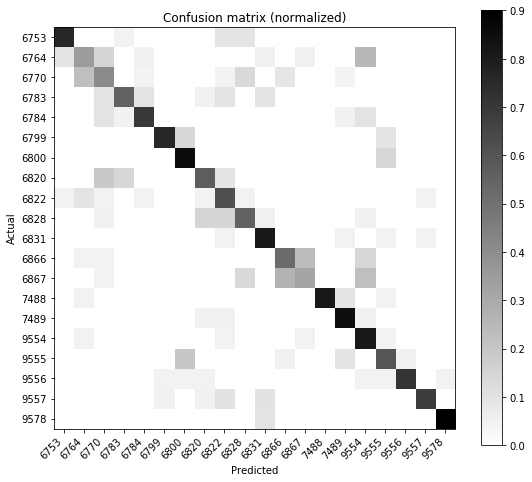

In [22]:
from pandas_ml import ConfusionMatrix


with open('adaboost_svc_5000.pickle', 'rb') as f:
    clf_svc_5000  = pickle.load(f)
    
predictions = clf_svc_5000.predict(x_test)
print("score:", clf_svc_5000.score(x_test, y_test))
cm = ConfusionMatrix(y_test, predictions)
cm.plot(normalized=True)
plt.savefig("adaboost_svc_5000")

score: 0.6416464891041163


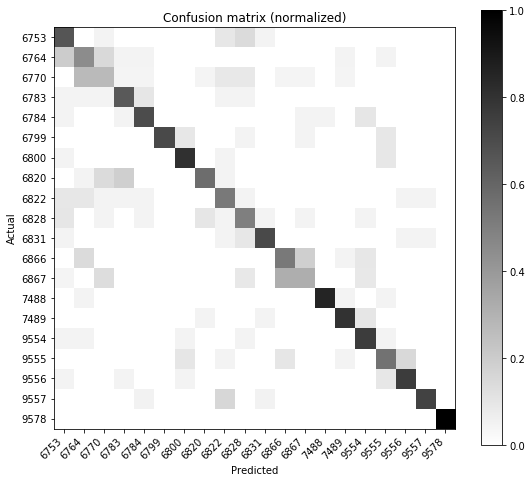

In [27]:
from pandas_ml import ConfusionMatrix


with open('adaboost_logistic_regression_100.pickle', 'rb') as f:
    clf_lr_100  = pickle.load(f)
    
predictions = clf_lr_100.predict(x_test)
print("score:", clf_lr_100.score(x_test, y_test))
cm = ConfusionMatrix(y_test, predictions)
cm.plot(normalized=True)
plt.savefig("adaboost_logistic_regression_500")